### 0. 가상환경 설정

- (1) Conda 사용 시 
    - 가상환경 생성: 
    ```conda create --name sam3d python=3.11```
    - 가상환경 활성화: 
    ```conda activate sam3d```
- (2) venv (python 기본) 사용 시
    - 가상환경 생성: 
    ```python3.10 -m venv sam3d```
    - 가상환경 활성화 (Linux / macOS): 
    ```source sam3d/bin/activate```
    - 가상환경 활성화 (Windows (cmd)): 
    ```.\sam3d\Scripts\activate```

### 1. 필요 라이브러리 설치

- 터미널에 ```pip install datasets pillow``` 실행하거나, 아래 셀 실행 후 노트북 Restart

In [ ]:
!pip install datasets pillow

In [ ]:
!conda install matplotlib numpy

- ```pip install ipykernel``` 해야 할 수도 있음

### 2. 데이터셋 다운로드하기

환경 변수 설정 

- 아래 셀 실행 후 ```<your-huggingface-token>``` 입력

In [1]:
import os, getpass
os.environ["HF_TOKEN"] = getpass.getpass("Paste your HF token (input hidden): ")

다운로드

- ```3D_train_npz_all/CT/CT_Lungs/``` 기준 10~15분 내외 소요 (419개 파일)

In [4]:
import os, time, numpy as np
from huggingface_hub import snapshot_download

HF_TOKEN = os.getenv("HF_TOKEN")
if not HF_TOKEN:
    raise RuntimeError("HF_TOKEN 환경변수를 설정하세요.")

os.environ["HF_HUB_DISABLE_XET"] = "1"

REPO_ID = "junma/CVPR-BiomedSegFM"
# ALLOW = ["3D_train_npz_all/CT/CT_LiverTumor/*.npz"]
ALLOW = ["3D_train_npz_all/CT/CT_Lungs/*.npz"]

SAVE_DIR = os.path.expanduser("./data/BiomedSegFM_Lungs") # 저장 위치 설정 

def safe_snapshot_download(retries=5, base_sleep=3):
    for i in range(retries):
        try:
            return snapshot_download(
                repo_id=REPO_ID,
                repo_type="dataset",
                token=HF_TOKEN,
                allow_patterns=ALLOW,
                local_dir=SAVE_DIR, 
                local_dir_use_symlinks=False, 
                max_workers=2,
            )
        except Exception as e:  
            if "429" in str(e):
                sleep_s = base_sleep * (2 ** i)
                print(f"[429] Too Many Requests - {sleep_s}s 후 재시도...")
                time.sleep(sleep_s)
            else:
                raise
    raise RuntimeError("허깅페이스 다운로드 재시도 실패")

local_dir = safe_snapshot_download()
print("Downloaded to:", local_dir)


/opt/anaconda3/envs/sam3d/lib/python3.11/site-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `snapshot_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
Fetching ... files: 419it [10:45,  1.54s/it]

Downloaded to: /Users/sonhuigyeong/3DSAM-LLA/notebooks/data/BiomedSegFM_Lungs


저장 위치 백업 (노트북 Restart 이후 초기화 될 때를 대비해서)

In [2]:
local_dir = "/Users/sonhuigyeong/3DSAM-LLA/notebooks/data/BiomedSegFM_Lungs" 

### 3. 데이터 확인하기

npz 파일 목록 확인

In [3]:
import glob, os

base_dir = os.path.join(
    local_dir, "3D_train_npz_all", "CT", "CT_Lungs"
)
files = sorted(glob.glob(os.path.join(base_dir, "*.npz")))
print(f"총 {len(files)}개 파일 발견")
print("예시:", files[:3])


총 419개 파일 발견
예시: ['/Users/sonhuigyeong/3DSAM-LLA/notebooks/data/BiomedSegFM_Lungs/3D_train_npz_all/CT/CT_Lungs/CT_LungMasks_LUNG1-001.npz', '/Users/sonhuigyeong/3DSAM-LLA/notebooks/data/BiomedSegFM_Lungs/3D_train_npz_all/CT/CT_Lungs/CT_LungMasks_LUNG1-002.npz', '/Users/sonhuigyeong/3DSAM-LLA/notebooks/data/BiomedSegFM_Lungs/3D_train_npz_all/CT/CT_Lungs/CT_LungMasks_LUNG1-004.npz']


npz 파일 하나 불러오기

In [4]:
import numpy as np
import matplotlib.pyplot as plt

sample_path = files[0]  # 첫 번째 케이스 예시
data = np.load(sample_path)

imgs = data["imgs"]   # shape: (D, H, W)
gts = data["gts"]     # shape: (D, H, W)
spacing = data["spacing"]

print("Image shape:", imgs.shape)
print("GT shape:", gts.shape)
print("Spacing:", spacing)
print("Pixel range:", imgs.min(), imgs.max())


Image shape: (86, 512, 512)
GT shape: (86, 512, 512)
Spacing: [0.9765625 0.9765625 3.       ]
Pixel range: 0 255


시각화 (가운데 단면 보기)

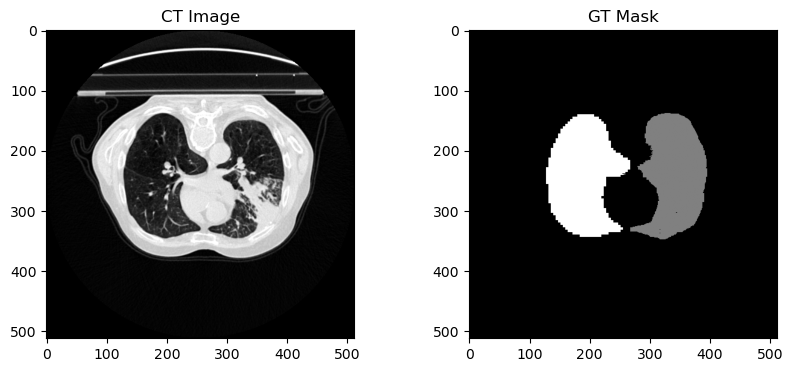

In [10]:
slice_idx = imgs.shape[0] // 2

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("CT Image")
plt.imshow(imgs[slice_idx], cmap="gray")

plt.subplot(1, 2, 2)
plt.title("GT Mask")
plt.imshow(gts[slice_idx], cmap="gray")
plt.show()


시각화 (x, y, z축)

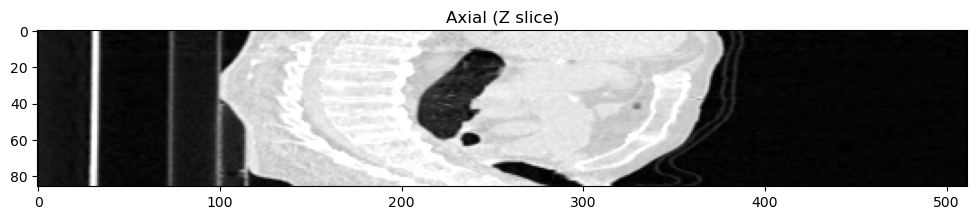

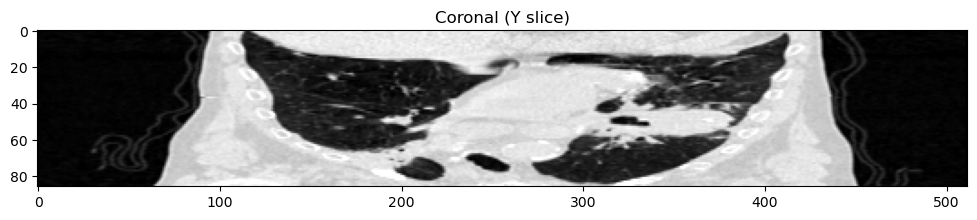

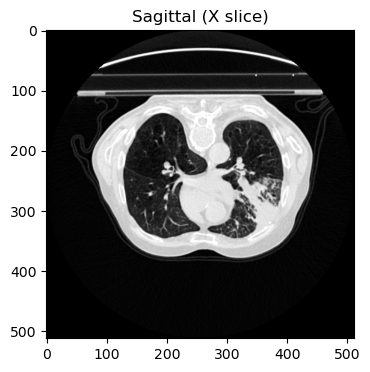

In [6]:
def show_slices(imgs):
    h, w, d = imgs.shape

    plt.figure(figsize=(12,4))
    plt.imshow(imgs[:,:,d//2], cmap='gray')
    plt.title("Axial (Z slice)")
    plt.show()

    plt.figure(figsize=(12,4))
    plt.imshow(imgs[:,w//2,:], cmap='gray')
    plt.title("Coronal (Y slice)")
    plt.show()

    plt.figure(figsize=(12,4))
    plt.imshow(imgs[h//2,:,:], cmap='gray')
    plt.title("Sagittal (X slice)")
    plt.show()

show_slices(imgs)

3D 시각화

- ```pip install napari``` 필요  
- ```conda install -c conda-forge pyqt pyside2``` 필요 

- napari를 이용해 실행하면, 3D 스크롤, 회전, 투명도 조절, 단면 탐색이 가능하다.

In [5]:
import numpy as np
import napari

imgs = data["imgs"]     # (D,H,W)
gts = data["gts"]

# napari 3D viewer 실행
viewer = napari.Viewer(ndisplay=3)  # 3D 모드
viewer.add_image(imgs, name="CT", colormap="gray")
viewer.add_labels(gts, name="Tumor Mask", opacity=0.3)
napari.run()

(선택) PyTorch Dataset 형태로 변환

- ```pip install torch``` 필요 

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

class LiverTumorDataset(Dataset):
    def __init__(self, npz_files):
        self.files = npz_files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = np.load(self.files[idx])
        imgs = torch.tensor(data["imgs"], dtype=torch.float32).unsqueeze(0) / 255.0
        gts = torch.tensor(data["gts"], dtype=torch.long)
        return imgs, gts

dataset = LiverTumorDataset(files)
print("샘플 개수:", len(dataset))

imgs, gts = dataset[0]
print("Tensor shapes:", imgs.shape, gts.shape)


샘플 개수: 419
Tensor shapes: torch.Size([1, 86, 512, 512]) torch.Size([86, 512, 512])
